In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from loss import FocalLoss, BinaryDiceLoss
from utils import normalize
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import os
import random
import numpy as np
from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from visualization import visualizer

from metrics import image_level_metrics, pixel_level_metrics, image_level_threshold
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

---
# AnomalyCLIP

In [2]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--data_path", type=str, default="./data/mvtec", help="path to test dataset")
parser.add_argument("--save_path", type=str, default='./results/CP/mvtec_pixel', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./checkpoints/9_12_4_multiscale/epoch_15.pth', help='path to checkpoint')
# model
parser.add_argument("--dataset", type=str, default='mvtec')
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--metrics", type=str, default='image-pixel-level')
parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

args = parser.parse_args(args=[])

In [3]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device ===> {device}')
AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list
print(f'obj_list ===> {obj_list}\n')

train_results = {}
train_metrics = {}
for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []
    train_metrics[obj] = {}
    train_metrics[obj]['pixel-auroc'] = 0
    train_metrics[obj]['pixel-aupro'] = 0
    train_metrics[obj]['image-auroc'] = 0
    train_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

device ===> cuda
name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** train ********************** 

obj_list ===> ['carpet', 'wood', 'metal_nut', 'toothbrush']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 807/807 [05:37<00:00,  2.39it/s]


In [4]:
train_results['wood']['gt_sp']

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 ten

---
# CP

In [5]:
# # Problem setup
# n=21 # number of calibration points
# alpha = 0.1 # 1-alpha is the desired coverage

# smx = np.array(list(zip(results['toothbrush']['pr_sp_n'], results['toothbrush']['pr_sp'])))
# labels = np.array(results['toothbrush']['gt_sp'])
# smx

In [6]:
# # Split the softmax scores into calibration and validation sets (save the shuffling)
# idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
# np.random.shuffle(idx)
# cal_smx, val_smx = smx[idx], smx[~idx]
# cal_labels, val_labels = labels[idx], labels[~idx]

# print(idx)
# print(cal_labels)
# print(val_labels)

In [7]:
# cal_smx

In [8]:
# # 1: get conformal scores. n = calib_Y.shape[0]
# cal_scores = 1-cal_smx[np.arange(n), cal_labels]
# cal_scores

In [9]:
# # 2: get adjusted quantile
# q_level = np.ceil((n+1)*(1-alpha))/n
# qhat = np.quantile(cal_scores, q_level, method='higher')
# prediction_sets = val_smx >= (1-qhat) # 3: form prediction sets

In [10]:
# # Calculate empirical coverage
# empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
# print(f"The empirical coverage is: {empirical_coverage}")

---
# Outlier

In [11]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list

test_results = {}
test_metrics = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []
    test_metrics[obj] = {}
    test_metrics[obj]['pixel-auroc'] = 0
    test_metrics[obj]['pixel-aupro'] = 0
    test_metrics[obj]['image-auroc'] = 0
    test_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 353/353 [06:07<00:00,  1.04s/it]


### 1. train data에서 q_hat 계산

In [12]:
scores = np.array(train_results['carpet']['pr_sp'])  # train dataset

n = len(scores)
alpha = 0.1
q_level = np.ceil((n+1)*(1-alpha))/n 
train_qhat = np.quantile(scores, q_level, method='higher')
print(f'n ===> {n}')
print(f'q_level ===> {q_level}')
print(f'train_qhat ===> {train_qhat}')

n ===> 280
q_level ===> 0.9035714285714286
train_qhat ===> 0.25365903973579407


In [13]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = (test_results['carpet']['pr_sp'] > train_qhat)
for t, p in zip(y_true, y_scores):
    print(t, ':', p)
# print(f'y_true ===> \n{y_true} \n\ny_scores ===> \n{y_scores}')

1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : True
0 : True
0 : True
0 : False
0 : False
0 : False
0 : True
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
0 : False
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : True
1 : 

In [14]:
p = precision_score(y_true, y_scores)
r = recall_score(y_true, y_scores)


print(f'precision: {round(p, 3)} \nrecall: {round(r, 3)}')

precision: 0.957 
recall: 1.0


In [15]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

print(len(scores), len(y_true), len(y_score_list), end='\n')

807 353 353


In [16]:
for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = ( y_score_list > train_qhat)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

train_qhat: 0.9858862161636353 
precision: 0.9603 
recall: 0.5331


### 2. calibration data (only normal)

In [17]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = np.array(test_results['carpet']['pr_sp'])

y_all = sorted(list(zip(y_true, y_scores)))
print(y_all)

[(0, 0.17128347), (0, 0.17522913), (0, 0.18888567), (0, 0.1953873), (0, 0.19682331), (0, 0.19742927), (0, 0.20378216), (0, 0.20381261), (0, 0.20465273), (0, 0.20693024), (0, 0.20695265), (0, 0.20697682), (0, 0.20836677), (0, 0.21105494), (0, 0.21405418), (0, 0.21410057), (0, 0.21462946), (0, 0.22497368), (0, 0.23117892), (0, 0.23289624), (0, 0.23614268), (0, 0.24377878), (0, 0.24430126), (0, 0.2482155), (0, 0.2641099), (0, 0.26810297), (0, 0.27282953), (0, 0.29031515), (1, 0.28140315), (1, 0.3079043), (1, 0.31856352), (1, 0.392282), (1, 0.39272735), (1, 0.39417228), (1, 0.40466717), (1, 0.40509227), (1, 0.41140708), (1, 0.42897922), (1, 0.43200743), (1, 0.46275836), (1, 0.49084774), (1, 0.530131), (1, 0.5315469), (1, 0.5483669), (1, 0.5552129), (1, 0.5572467), (1, 0.58006865), (1, 0.59770864), (1, 0.59911597), (1, 0.62391824), (1, 0.6344057), (1, 0.63594115), (1, 0.6595528), (1, 0.66139066), (1, 0.6657083), (1, 0.6809939), (1, 0.6889159), (1, 0.6955137), (1, 0.71222687), (1, 0.7358459)

##### class 1개


In [18]:
n = 10
alpha = 0.1 # 1-alpha is the desired coverage

p_list = []
r_list = []

for i in range(19):
    score_list = np.array(y_all[i:i + 10])[:, 1]
    y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
    y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

    q_level = np.ceil((n+1)*(1-alpha))/n 
    qhat = np.quantile(score_list, q_level, method='higher')
    
    y_pred = y_pred_list > qhat

    # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
    print(f'{i}\n{(y_label), (y_pred)}')

    p = precision_score(y_label, y_pred)
    p_list.append(p)

    r = recall_score(y_label, y_pred)
    r_list.append(r)

print(f'precision: {round(sum(p_list)/len(p_list), 3)} \nrecall: {round(sum(r_list)/len(r_list), 3)}')

0
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, 

##### 전체 데이터 (각 클래스 별)

In [19]:
cali_only_nor_res = {}
for obj in obj_list:
    y_true = np.array(test_results[obj]['gt_sp'])
    y_scores = np.array(test_results[obj]['pr_sp'])

    y_all = sorted(list(zip(y_true, y_scores)))
    n = 10
    alpha = 0.1 # 1-alpha is the desired coverage

    p_list = []
    r_list = []

    for i in range(len(np.where(y_true == 0))):
        score_list = np.array(y_all[i:i + 10])[:, 1]
        y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred)
        p_list.append(p)

        r = recall_score(y_label, y_pred)
        r_list.append(r)

    cali_only_nor_res[obj] = (sum(p_list)/len(p_list), sum(r_list)/len(r_list))

print(cali_only_nor_res)

{'carpet': (0.8317757009345794, 1.0), 'wood': (0.8656716417910447, 0.9666666666666667), 'metal_nut': (0.883495145631068, 0.978494623655914), 'toothbrush': (0.9166666666666666, 0.7333333333333333)}


##### 모든 클래스 통합

In [20]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))


In [21]:
normal_all_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.8625 
recall: 0.7447


15
qhat 0.9893184304237366
precision: 0.8674 
recall: 0.7253


20
qhat 0.9893184304237366
precision: 0.8722 
recall: 0.7028


25
qhat 0.9893184304237366
precision: 0.8767 
recall: 0.6763


30
qhat 0.9884844422340393
precision: 0.8824 
recall: 0.6555


35
qhat 0.9884844422340393
precision: 0.8895 
recall: 0.6393


40
qhat 0.9876382350921631
precision: 0.898 
recall: 0.6305


45
qhat 0.9876382350921631
precision: 0.9064 
recall: 0.6154


50
qhat 0.987127423286438
precision: 0.9164 
recall: 0.6083


55
qhat 0.987127423286438
precision: 0.9265 
recall: 0.5947




##### abnormal 개수 122

In [22]:
import random
# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 150)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

normal_122_qhat = []

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_122_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.7458 
recall: 0.7557


15
qhat 0.9893184304237366
precision: 0.7539 
recall: 0.7372


20
qhat 0.9893184304237366
precision: 0.7619 
recall: 0.7157


25
qhat 0.9893184304237366
precision: 0.7698 
recall: 0.6903


30
qhat 0.9884844422340393
precision: 0.7796 
recall: 0.6708


35
qhat 0.9884844422340393
precision: 0.7909 
recall: 0.6527


40
qhat 0.9876382350921631
precision: 0.8053 
recall: 0.6441


45
qhat 0.9876382350921631
precision: 0.8203 
recall: 0.6314


50
qhat 0.987127423286438
precision: 0.8382 
recall: 0.6267


55
qhat 0.987127423286438
precision: 0.8566 
recall: 0.6154




In [24]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 172)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]

normal_100_qhat = []

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_100_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(n)
    # print(f'score_list\n{len(score_list)}\n')
    print('qhat', qhat)
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

10
qhat 0.9893184304237366
precision: 0.709 
recall: 0.7562


15
qhat 0.9893184304237366
precision: 0.7179 
recall: 0.7377


20
qhat 0.9893184304237366
precision: 0.7267 
recall: 0.7162


25
qhat 0.9893184304237366
precision: 0.7355 
recall: 0.6909


30
qhat 0.9884844422340393
precision: 0.7465 
recall: 0.6718


35
qhat 0.9884844422340393
precision: 0.7596 
recall: 0.6554


40
qhat 0.9876382350921631
precision: 0.7754 
recall: 0.6466


45
qhat 0.9876382350921631
precision: 0.7905 
recall: 0.6283


50
qhat 0.987127423286438
precision: 0.8097 
recall: 0.6203


55
qhat 0.987127423286438
precision: 0.8301 
recall: 0.6073




### 3. calibraion data (all) 

##### class 1개

In [25]:
y_true = np.array(test_results['carpet']['gt_sp'])
y_scores = np.array(test_results['carpet']['pr_sp'])

y_all = list(zip(y_true, y_scores))

n = 10
alpha = 0.1 # 1-alpha is the desired coverage

p_list_all = []
r_list_all = []

for i in range(len(y_true)-10):
    score_list = np.array(y_all[i:i + 10])[:, 1]
    y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
    y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

    q_level = np.ceil((n+1)*(1-alpha))/n 
    qhat = np.quantile(score_list, q_level, method='higher')
    
    y_pred = y_pred_list > qhat

    # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
    print(f'{i}\n{len(y_label), y_label,  len(y_pred), y_pred}')

    p = precision_score(y_label, y_pred)
    p_list_all.append(p)

    r = recall_score(y_label, y_pred)
    r_list_all.append(r)

print(f'precision: {round(sum(p_list_all)/len(p_list_all), 3)} \nrecall: {round(sum(r_list_all)/len(r_list_all), 3)}')

0
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

71
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fal

##### 전체 데이터 (클래스별로)

In [26]:
cali_all_res = {}
for obj in obj_list:
    y_true = np.array(test_results[obj]['gt_sp'])
    y_scores = np.array(test_results[obj]['pr_sp'])

    y_all = list(zip(y_true, y_scores))

    n = 10
    alpha = 0.1 # 1-alpha is the desired coverage

    p_list_all = []
    r_list_all = []

    for i in range(len(y_true)-10):
        score_list = np.array(y_all[i:i + 10])[:, 1]
        y_pred_list = np.array(y_all[:i] + y_all[i + 10:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + 10:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        
        y_pred = y_pred_list > qhat

        # print(f'score_list ===> \n{len(score_list)}, {score_list}\n\ny_pred_list ===> \n{len(y_pred_list)}, {y_pred_list} \n\ny_pred ===> \n {len(y_pred)}, {y_pred}')
        print(f'{i}\n{len(y_label), y_label,  len(y_pred), y_pred}')

        p = precision_score(y_label, y_pred)
        p_list_all.append(p)

        r = recall_score(y_label, y_pred)
        r_list_all.append(r)
    print(obj, y_pred, '\n', len(p_list_all), len(r_list_all), '\n')

    cali_all_res[obj] = (sum(p_list_all)/len(p_list_all), sum(r_list_all)/len(r_list_all))

print(cali_all_res)

0
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

67
(107, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.]), 107, array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, Fal

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:

32
(105, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.]), 105, array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
        True, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, Fals

c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 클래스 통합 (전체)

In [29]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = np.array(list(zip(y_true, y_score_list)))
# y_all = np.array(y_all)


In [30]:
alpha = 0.1 # 1-alpha is the desired coverage

# print(f'y_all \n{len(y_all)}\n{y_all}')
# print(np.array(y_all).shape)

all_all_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.9217 
recall: 0.3993


---15---
precision: 0.9145 
recall: 0.3651


---20---
precision: 0.9041 
recall: 0.3355


---25---
precision: 0.8911 
recall: 0.3146


---30---
precision: 0.9579 
recall: 0.3367


---35---
precision: 0.9451 
recall: 0.3172


---40---
precision: 0.9592 
recall: 0.3174


---45---
precision: 0.9621 
recall: 0.3003


---50---
precision: 0.9622 
recall: 0.2993


---55---
precision: 0.9645 
recall: 0.285




##### abnormal 122 개

In [31]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))
# y_all = np.array(y_all)

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 150)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]
y_all = np.array(y_all)


all_122_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_122_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.8455 
recall: 0.4422


---15---
precision: 0.8368 
recall: 0.3912


---20---
precision: 0.8174 
recall: 0.3447


---25---
precision: 0.7934 
recall: 0.3085


---30---
precision: 0.8354 
recall: 0.3156


---35---
precision: 0.8098 
recall: 0.2831


---40---
precision: 0.9141 
recall: 0.2747


---45---
precision: 0.8914 
recall: 0.245


---50---
precision: 0.8623 
recall: 0.2298


---55---
precision: 0.8344 
recall: 0.2029




##### abnormal 100개

In [32]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))
# y_all = np.array(y_all)

# y_true = 1인 인덱스 찾기
y_true_1_indices = [i for i, (y, _) in enumerate(y_all) if y == 1]

# y_true = 1인 것 중 랜덤으로 150개 선택하여 제거
remove_indices = random.sample(y_true_1_indices, 172)

# 제거할 인덱스 제외한 나머지 요소들로 y_all 업데이트
y_all = [elem for i, elem in enumerate(y_all) if i not in remove_indices]
y_all = np.array(y_all)

all_100_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_100_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.7941 
recall: 0.4205


---15---
precision: 0.7907 
recall: 0.372


---20---
precision: 0.7772 
recall: 0.3241


---25---
precision: 0.7549 
recall: 0.2845


---30---
precision: 0.8016 
recall: 0.3058


---35---
precision: 0.7742 
recall: 0.2719


---40---
precision: 0.6944 
recall: 0.3531


---45---
precision: 0.6629 
recall: 0.3318


---50---
precision: 0.7782 
recall: 0.327


---55---
precision: 0.7473 
recall: 0.2984




---
# 픽셀 단위로 진행

In [33]:
# # print(len(results['toothbrush']['anomaly_maps']))
# # print(results['toothbrush']['anomaly_maps'][0].shape)

# mean_score_maps = np.array(list(torch.mean(anomaly_map).item() for anomaly_map in results['toothbrush']['anomaly_maps']))
# mean_score = np.mean(mean_score_maps)

In [34]:
# test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [35]:
# from visualization import visualizer


# model.to(device)
# features_list = args.features_list

# results = {}
# metrics = {}
# for obj in obj_list:
#     results[obj] = {}
#     results[obj]['gt_sp'] = []
#     results[obj]['pr_sp'] = []
#     results[obj]['pr_sp_n'] = []
#     results[obj]['imgs_masks'] = []
#     results[obj]['anomaly_maps'] = []
#     metrics[obj] = {}
#     metrics[obj]['pixel-auroc'] = 0
#     metrics[obj]['pixel-aupro'] = 0
#     metrics[obj]['image-auroc'] = 0
#     metrics[obj]['image-ap'] = 0

# for idx, items in enumerate(tqdm(test_dataloader)):
    
#     image = items['img'].to(device)
#     cls_name = items['cls_name']
#     cls_id = items['cls_id']
#     gt_mask = items['img_mask']
#     gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
#     results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
#     results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

#     with torch.no_grad():
#         image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
#         image_features = image_features / image_features.norm(dim=-1, keepdim=True)

#         text_probs = image_features @ text_features.permute(0, 2, 1)
#         text_probs = (text_probs/0.07).softmax(-1)
#         text_probs_a = text_probs[:, 0, 1]
#         text_probs_n = text_probs[:, 0, 0]
#         anomaly_map_list = []
#         for idx, patch_feature in enumerate(patch_features):
#             if idx >= args.feature_map_layer[0]:
#                 patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
#                 similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
#                 similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
#                 anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
#                 anomaly_map_binary = (anomaly_map > mean_score).float()
#                 anomaly_map_list.append(anomaly_map_binary)

#         anomaly_map_binary = torch.stack(anomaly_map_list)
        
#         anomaly_map_binary = anomaly_map_binary.sum(dim = 0)
#         results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
#         results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
#         anomaly_map_binary = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map_binary.detach().cpu()], dim = 0 )
#         results[cls_name[0]]['anomaly_maps'].append(anomaly_map_binary)

#         # visualizer(items['img_path'], anomaly_map_binary.detach().cpu().numpy(), args.image_size, args.save_path, cls_name)
        
# table_ls = []
# image_auroc_list = []
# image_ap_list = []
# pixel_auroc_list = []
# pixel_aupro_list = []
# for obj in obj_list:
#     table = []
#     table.append(obj)
#     results[obj]['imgs_masks'] = torch.cat(results[obj]['imgs_masks'])
#     results[obj]['anomaly_maps'] = torch.cat(results[obj]['anomaly_maps']).detach().cpu().numpy()

#     try:
#         image_auroc = image_level_metrics(results, obj, "image-auroc")
#         image_ap = image_level_metrics(results, obj, "image-ap")
#     except:
#         image_auroc = 0
#         image_ap = 0
#     try:
#         pixel_auroc = pixel_level_metrics(results, obj, "pixel-auroc")
#         pixel_aupro = pixel_level_metrics(results, obj, "pixel-aupro")
#     except:
#         pixel_auroc = 0
#         pixel_aupro = 0
#     table.append(str(np.round(pixel_auroc * 100, decimals=1)))
#     table.append(str(np.round(pixel_aupro * 100, decimals=1)))
#     table.append(str(np.round(image_auroc * 100, decimals=1)))
#     table.append(str(np.round(image_ap * 100, decimals=1)))

#     image_auroc_list.append(image_auroc)
#     image_ap_list.append(image_ap) 
#     pixel_auroc_list.append(pixel_auroc)
#     pixel_aupro_list.append(pixel_aupro)
#     table_ls.append(table)

#     # logger
# table_ls.append(['mean', str(np.round(np.mean(pixel_auroc_list) * 100, decimals=1)),
#                 str(np.round(np.mean(pixel_aupro_list) * 100, decimals=1)), 
#                 str(np.round(np.mean(image_auroc_list) * 100, decimals=1)),
#                 str(np.round(np.mean(image_ap_list) * 100, decimals=1))])
# results = tabulate(table_ls, headers=['objects', 'pixel_auroc', 'pixel_aupro', 'image_auroc', 'image_ap'], tablefmt="pipe")
# print("\n%s", results)

---
# 픽셀별 평균값

In [36]:
# anomaly_maps = torch.stack(results['toothbrush']['anomaly_maps'])  # (60, 1, 518, 518) 형태로 스택
# mean_score_map = anomaly_maps.mean(dim=0)  # (1, 518, 518) 형태로 평균 계산
# print(mean_score_map.shape)

In [37]:
# from visualization import visualizer
# test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# model.to(device)
# features_list = args.features_list
# mean_score_map.to(device)

# results = {}
# metrics = {}
# for obj in obj_list:
#     results[obj] = {}
#     results[obj]['gt_sp'] = []
#     results[obj]['pr_sp'] = []
#     results[obj]['pr_sp_n'] = []
#     results[obj]['imgs_masks'] = []
#     results[obj]['anomaly_maps'] = []
#     metrics[obj] = {}
#     metrics[obj]['pixel-auroc'] = 0
#     metrics[obj]['pixel-aupro'] = 0
#     metrics[obj]['image-auroc'] = 0
#     metrics[obj]['image-ap'] = 0

# for idx, items in enumerate(tqdm(test_dataloader)):
    
#     image = items['img'].to(device)
#     cls_name = items['cls_name']
#     cls_id = items['cls_id']
#     gt_mask = items['img_mask']
#     gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
#     results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
#     results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

#     with torch.no_grad():
#         image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
#         image_features = image_features / image_features.norm(dim=-1, keepdim=True)

#         text_probs = image_features @ text_features.permute(0, 2, 1)
#         text_probs = (text_probs/0.07).softmax(-1)
#         text_probs_a = text_probs[:, 0, 1]
#         text_probs_n = text_probs[:, 0, 0]
#         anomaly_map_list = []
#         for idx, patch_feature in enumerate(patch_features):
#             if idx >= args.feature_map_layer[0]:
#                 patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
#                 similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
#                 similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
#                 anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
#                 mean_score_map = mean_score_map.to(anomaly_map.device)  
#                 anomaly_map_binary = (anomaly_map > mean_score_map).float()
#                 anomaly_map_list.append(anomaly_map_binary)

#         anomaly_map_binary = torch.stack(anomaly_map_list)
        
#         anomaly_map_binary = anomaly_map_binary.sum(dim = 0)
#         results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
#         results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
#         anomaly_map_binary = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map_binary.detach().cpu()], dim = 0 )
#         results[cls_name[0]]['anomaly_maps'].append(anomaly_map_binary)

#         visualizer(items['img_path'], anomaly_map_binary.detach().cpu().numpy(), args.image_size, args.save_path, cls_name)
        
# table_ls = []
# image_auroc_list = []
# image_ap_list = []
# pixel_auroc_list = []
# pixel_aupro_list = []
# for obj in obj_list:
#     table = []
#     table.append(obj)
#     results[obj]['imgs_masks'] = torch.cat(results[obj]['imgs_masks'])
#     results[obj]['anomaly_maps'] = torch.cat(results[obj]['anomaly_maps']).detach().cpu().numpy()

#     try:
#         image_auroc = image_level_metrics(results, obj, "image-auroc")
#         image_ap = image_level_metrics(results, obj, "image-ap")
#     except:
#         image_auroc = 0
#         image_ap = 0


#     try:
#         pixel_auroc = pixel_level_metrics(results, obj, "pixel-auroc")
#         pixel_aupro = pixel_level_metrics(results, obj, "pixel-aupro")
#     except:
#         pixel_auroc = 0
#         pixel_aupro = 0
#     table.append(str(np.round(pixel_auroc * 100, decimals=1)))
#     table.append(str(np.round(pixel_aupro * 100, decimals=1)))
#     table.append(str(np.round(image_auroc * 100, decimals=1)))
#     table.append(str(np.round(image_ap * 100, decimals=1)))

#     image_auroc_list.append(image_auroc)
#     image_ap_list.append(image_ap) 
#     pixel_auroc_list.append(pixel_auroc)
#     pixel_aupro_list.append(pixel_aupro)
#     table_ls.append(table)

#     # logger
# table_ls.append(['mean', str(np.round(np.mean(pixel_auroc_list) * 100, decimals=1)),
#                 str(np.round(np.mean(pixel_aupro_list) * 100, decimals=1)), 
#                 str(np.round(np.mean(image_auroc_list) * 100, decimals=1)),
#                 str(np.round(np.mean(image_ap_list) * 100, decimals=1))])
# results = tabulate(table_ls, headers=['objects', 'pixel_auroc', 'pixel_aupro', 'image_auroc', 'image_ap'], tablefmt="pipe")
# print("\n%s", results)

---
# Plot
### 1. Score(scatter plot)

In [38]:
print(test_results.keys())
print(test_results['carpet'].keys())

color_list = ['orange', 'tomato', 'grey', 'lightsteelblue']

dict_keys(['carpet', 'wood', 'metal_nut', 'toothbrush'])
dict_keys(['gt_sp', 'pr_sp', 'pr_sp_n', 'imgs_masks', 'anomaly_maps'])


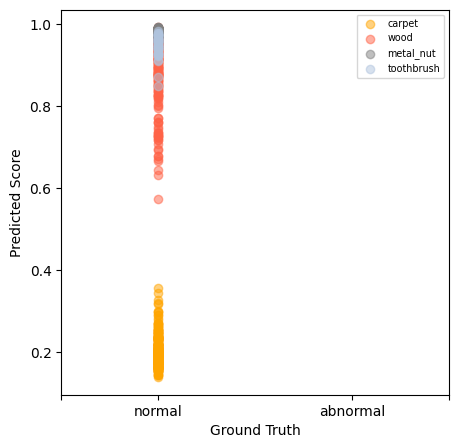

In [39]:
# train
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

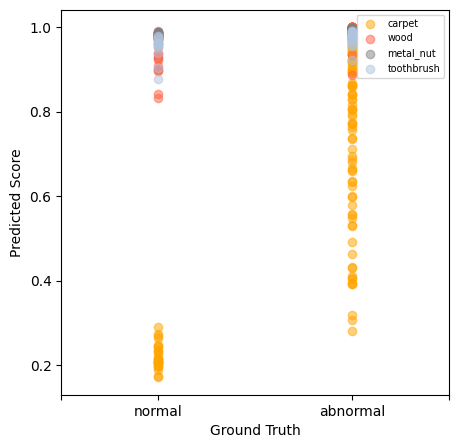

In [40]:
# test
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

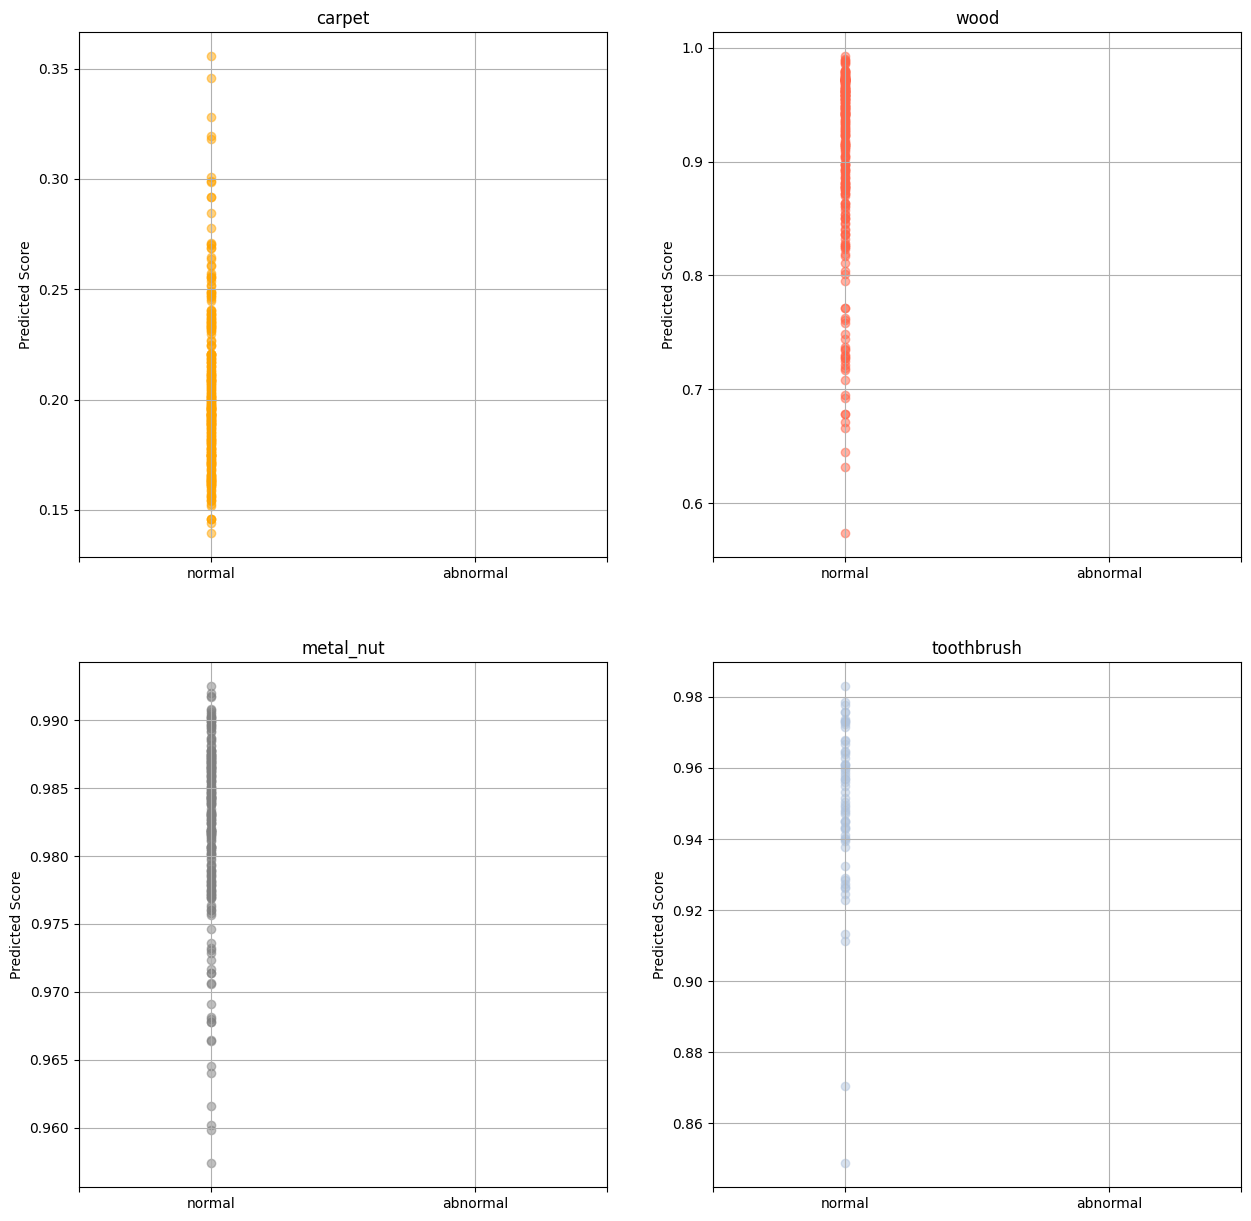

In [41]:
# train
plt.figure(figsize=(15, 15))
for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

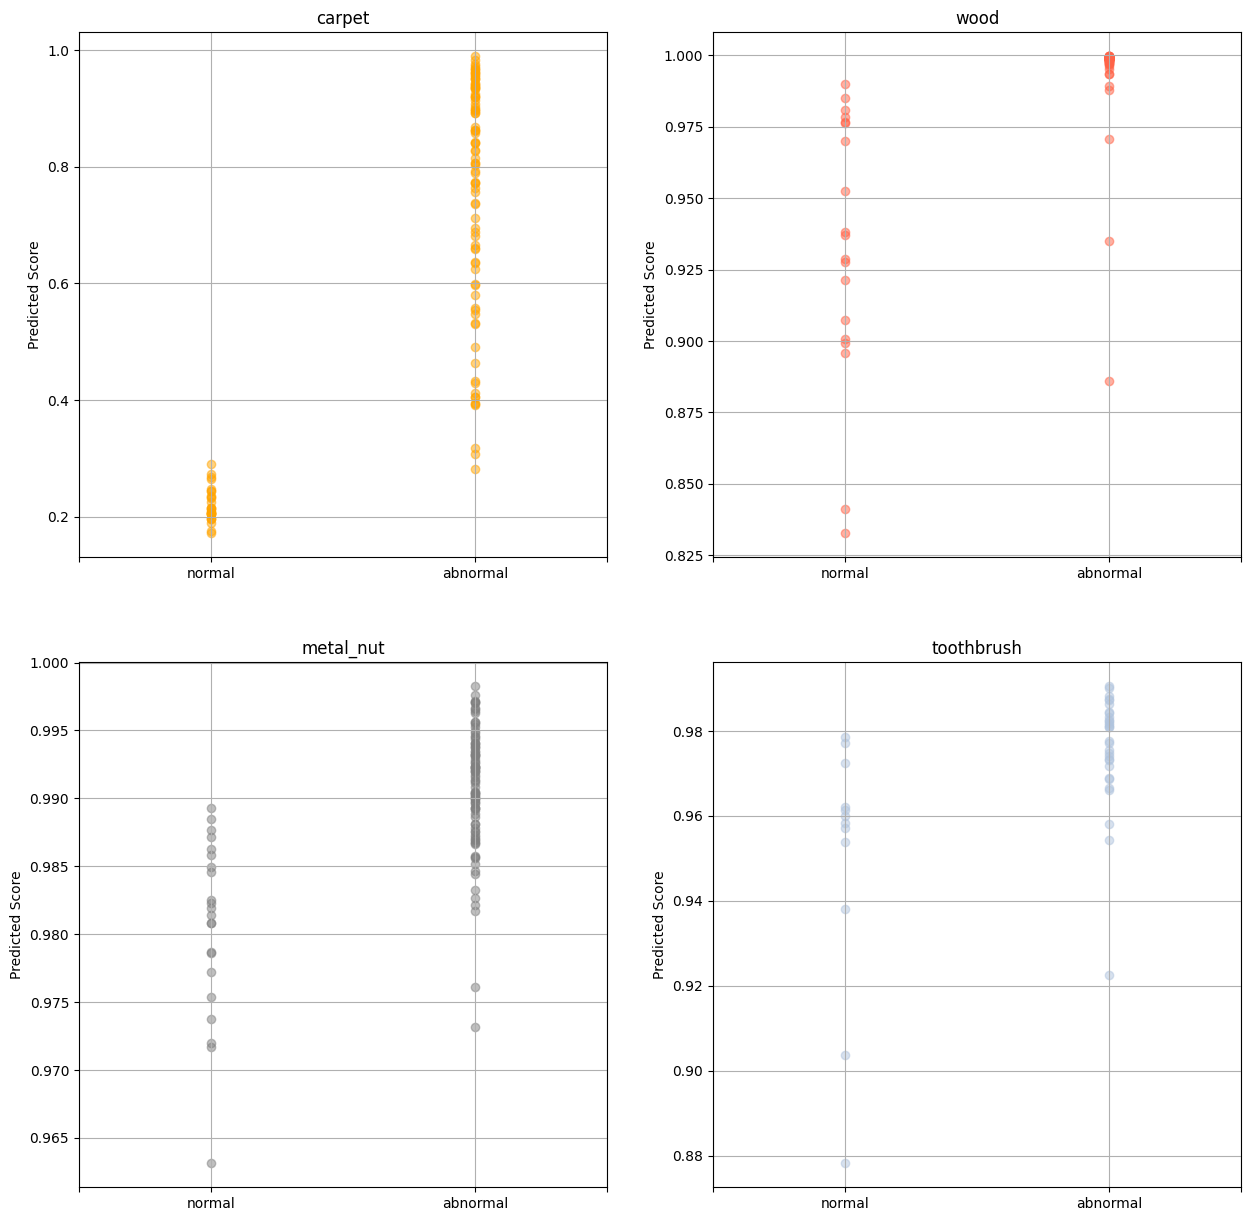

In [42]:
# test
plt.figure(figsize=(15, 15))
for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

### 2. qhat

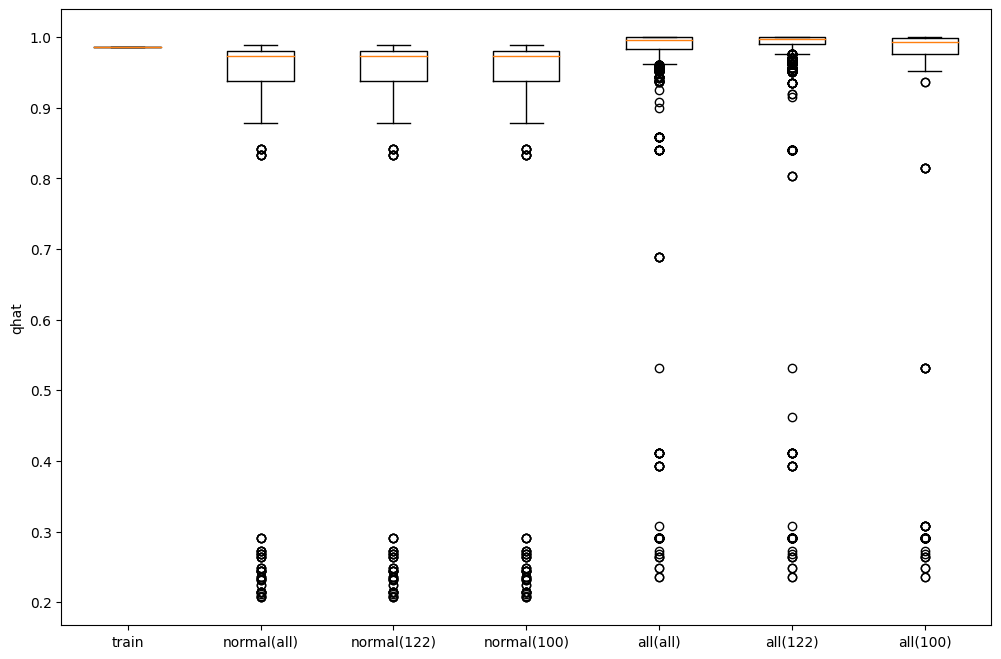

In [43]:
plt.figure(figsize=(12, 8))
# plt.boxplot(train_qhat, y=0)
plt.boxplot([train_qhat, normal_all_qhat, normal_122_qhat, normal_100_qhat, all_all_qhat, all_122_qhat, all_100_qhat])
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['train', 'normal(all)', 'normal(122)', 'normal(100)', 'all(all)', 'all(122)', 'all(100)'])
plt.ylabel('qhat')
plt.show()